In [2]:
import json
import logging
import time
import os
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import interpolate
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense

In [87]:
def blackscholes_price(K, T, S, vol, r=0, q=0, callput='call'):
    F = S*np.exp((r-q)*T)
    v = np.sqrt(vol**2*T)
    d1 = np.log(F/K)/v + 0.5*v
    d2 = d1 - v
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = opttype*(F*norm.cdf(opttype*d1)-K*norm.cdf(opttype*d2))*np.exp(-r*T)
    return price

In [66]:
def get_sample(num):
    return 80+40*np.random.uniform(0,1,[num,1])


class equation(object):
    
    def __init__(self,dim, total_time, num_time_interval):
        self.dim=dim
        self.total_time=total_time
        self.num_time_interval=num_time_interval
        self.delta_t = (self.total_time + 0.0) / self.num_time_interval
        self.sqrt_delta_t = np.sqrt(self.delta_t)
        self.sigma=0.2
        self.r=0
        
    def sample(self, num_sample):
        x_init=80+40*np.random.uniform(0,1,[num_sample,self.dim])
        dw_sample = np.random.randn(num_sample,
                                     self.dim,
                                     self.num_time_interval) * self.sqrt_delta_t
        x_sample = np.zeros([num_sample, self.dim, self.num_time_interval + 1])
        x_sample[:, :, 0] = np.ones([num_sample, self.dim]) * x_init
        
        factor = np.exp((self.r-(self.sigma**2)/2)*self.delta_t)
        for i in range(self.num_time_interval):
            x_sample[:, :, i + 1] = (factor * np.exp(self.sigma * dw_sample[:, :, i])) * x_sample[:, :, i]
        return dw_sample, x_sample
    
    def f_tf(self, t, x, y, z):
        return -self.r * y

    def g_tf(self, t, x):
        return tf.maximum(x - 100, 0)

In [67]:
dim, total_time, num_time_interval=1,1,10
eurOption=equation(dim, total_time, num_time_interval)

In [125]:
TF_DTYPE = tf.float32

class FeedForwardModeltest(object):

    def __init__(self,sess,dim, total_time, num_time_interval):
        self._sess = sess
        self.f_network = []
        self.num_iteration=30000
        self.batch_size=256
        self.logging_frequency=1000
        
        self.lr_boundaries=[2000]
        self.lr_values=list(np.array([1e-3, 1e-3]))
        
        self.dim=dim
        self.total_time=total_time
        self.num_time_interval=num_time_interval
        self.delta_t = (self.total_time + 0.0) / self.num_time_interval
        
        self.cdfCal=tfp.bijectors.NormalCDF()

    def train(self):
        start_time = time.time()
        
        
        dw_valid,x_valid = eurOption.sample(256)
        feed_dict_valid = {self._x: x_valid,self._dw:dw_valid,self.lambda1:0,self.lambda2:1, self._is_training: False}
        self._sess.run(tf.global_variables_initializer())
        
        for step in range(self.num_iteration+1):
            if step % self.logging_frequency == 0:
                dw_train,x_train = eurOption.sample(256)
                loss= self._sess.run(self._loss, feed_dict=feed_dict_valid)
                elapsed_time = time.time()-start_time+self._t_build
                #print(loss)
                print("step: %5u,loss: %.4e,  elapsed time %3u" % (step, loss, elapsed_time))
            loss=self._sess.run([self._loss ,self._train_ops], feed_dict={self._x: x_train,self._dw:dw_train,self.lambda1:0,
                                                                          self.lambda2:1,self._is_training: True})[0]

        graphs=self._sess.run(self.graphs, feed_dict=feed_dict_valid)[0]
        return graphs

    def build(self):
        start_time = time.time()
        time_stamp = np.arange(0, self.num_time_interval) * self.delta_t
        
        
        self.f_network.append(Dense(units = 11, input_shape = (1,), activation = 'relu'))
        self.f_network.append(Dense(units = 11, input_shape = (11,), activation = 'relu'))
        #self.f_network.append(Dense(units = 11, input_shape = (11,), activation = 'relu'))
        self.f_network.append(Dense(units = 1, input_shape = (11,), activation = 'relu')) 
        
        self._x = tf.placeholder(TF_DTYPE, [None,self.dim, self.num_time_interval+1], name='X')
        self._dw = tf.placeholder(TF_DTYPE, [None, self.dim, self.num_time_interval], name='dW')
        self.lambda1=tf.placeholder(TF_DTYPE, name='lambda1')
        self.lambda2=tf.placeholder(TF_DTYPE, name='lambda2')
        self._is_training = tf.placeholder(tf.bool)

        x = np.linspace(80, 120, 82)
        self.x = tf.constant(x, dtype=TF_DTYPE, shape=[1, 82, 1])

        with tf.variable_scope('forward'):
            y = self.f_network[0](self._x[:,:,0])
            y = self.f_network[1](y)
            y = self.f_network[2](y)
            #y = self.f_network[3](y)
            z = self.delta(self._x[:, :, 0],1-time_stamp[0])
            
            y_init=y+0.0
            
            for t in range(0, self.num_time_interval-1):
                y=y+tf.reduce_sum(z *0.2*self._x[:, :, t] * self._dw[:, :, t], 1, keepdims=True)
                z = self.delta(self._x[:, :, t],1-time_stamp[t])
            
            y=y+tf.reduce_sum(z * 0.2 *self._x[:, :, -2]* self._dw[:, :, -1], 1, keepdims=True)
            loss1 = y_init - tf.maximum(self._x[:,:,0]- 100, 0)
            loss2 = y - tf.maximum(self._x[:,:,-1]- 100, 0)
            self._loss = self.lambda1 * tf.reduce_mean(tf.square(loss1)) + self.lambda2 * tf.reduce_mean(tf.square(loss2))
            
            self.graphs = []
            l = self.x+0.0
            l = self.f_network[0](l)
            l = self.f_network[1](l)
            l = self.f_network[2](l)
            #l = self.f_network[3](l)
            self.graphs=l

        trainable_variables = tf.trainable_variables()
        grads = tf.gradients(self._loss, trainable_variables)
        
        global_step = tf.get_variable('global_step', [],
                                      initializer=tf.constant_initializer(0),
                                      trainable=False, dtype=tf.int32)
        learning_rate = tf.train.piecewise_constant(global_step,
                                                    self.lr_boundaries,
                                                    self.lr_values)
        
        #optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        apply_op = optimizer.apply_gradients(zip(grads, trainable_variables), global_step=global_step,name='train_step')
        all_ops = [apply_op] #+ self._extra_train_ops
        self._train_ops = tf.group(*all_ops)
        self._t_build = time.time()-start_time
        
    def delta(self,s,t):
        return self.cdfCal._forward((self.d1(s,t)))

    def d1(self,s,t):
        k=100
        r=0
        sigma=0.2
        return (tf.math.log(s/k)+(r+sigma*sigma/2)*t)/(sigma*np.sqrt(t))

step:     0,loss: 2.3694e+03,  elapsed time   0
step:  1000,loss: 3.9734e+01,  elapsed time   2
step:  2000,loss: 3.8944e+01,  elapsed time   4
step:  3000,loss: 3.8164e+01,  elapsed time   5
step:  4000,loss: 3.6264e+01,  elapsed time   7
step:  5000,loss: 2.9879e+01,  elapsed time   8
step:  6000,loss: 1.3810e+01,  elapsed time   9
step:  7000,loss: 1.0094e+01,  elapsed time  11
step:  8000,loss: 1.0256e+01,  elapsed time  13
step:  9000,loss: 1.0007e+01,  elapsed time  14
step: 10000,loss: 9.9093e+00,  elapsed time  16
step: 11000,loss: 1.0257e+01,  elapsed time  17
step: 12000,loss: 1.0248e+01,  elapsed time  19
step: 13000,loss: 1.0280e+01,  elapsed time  20
step: 14000,loss: 1.0255e+01,  elapsed time  22
step: 15000,loss: 1.0245e+01,  elapsed time  23
step: 16000,loss: 1.0286e+01,  elapsed time  25
step: 17000,loss: 9.7622e+00,  elapsed time  26
step: 18000,loss: 9.7880e+00,  elapsed time  28
step: 19000,loss: 9.7294e+00,  elapsed time  30
step: 20000,loss: 1.0118e+01,  elapsed t

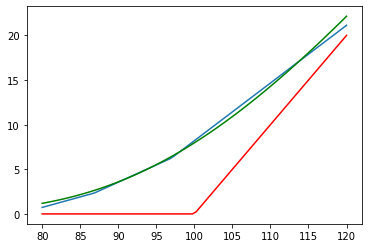

In [130]:
dim, total_time, num_time_interval=1,1,10
eurOption=equation(dim, total_time, num_time_interval)

tf.reset_default_graph()
with tf.Session() as sess:
    model = FeedForwardModeltest(sess,dim, total_time, num_time_interval)
    model.build()
    graphs = model.train()
g=graphs

fig, ax = plt.subplots()
ax.plot(np.linspace(80,120, 82),g.flatten())
ax.plot(np.linspace(80,120, 82),np.maximum(np.linspace(80,120, 82)-100,0),'r')
ax.plot(np.linspace(80,120, 82),blackscholes_price(100, 1, np.linspace(80,120, 82), 0.2, 0, 0, 'call'),'g')

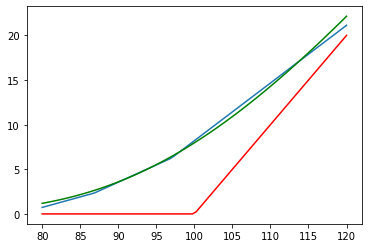

In [131]:
fig, ax = plt.subplots()
ax.plot(np.linspace(80,120, 82),g.flatten())
ax.plot(np.linspace(80,120, 82),np.maximum(np.linspace(80,120, 82)-100,0),'r')
ax.plot(np.linspace(80,120, 82),blackscholes_price(100, 1, np.linspace(80,120, 82), 0.2, 0, 0, 'call'),'g')